<a href="https://www.kaggle.com/code/sharanharsoor/step-by-step-guide-for-dl-models?scriptVersionId=122397190" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction.
In this notebook, we are going to understand a streamlined way of building a deep learning model (using the reference Fashion MNIST dataset).
1. Building a basic DL model. 
2. Learning Rate scheduling: (Step Decay)
3. Adaptive Optimise model: Adam
4. Hyperparameter tuning the architecture with KerasTuner.
5. Grid search CV for the rest of the parameters. 
6. Early Stopping model.
7. Manual Prediction check 
8. Test data accuracy.

# importing requiered libs. 

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier

import keras_tuner as kt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Read Data


In [3]:
# Reading input train and test data. 
# train data will be used for model building and evaluation. 
# Test data will be used to validate the model performance on unseen data.

train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")
x_test = test.loc[:, test.columns != "label"]
y_test = test['label']

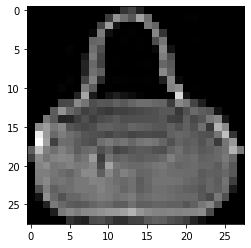

In [4]:
# sample plot of a row from CSV to show the image. 

Image_index = 20
img = train.loc[Image_index, train.columns != "label"].values.reshape((28,28))
plt.imshow(img,cmap='gray')

In [5]:
# Training data and label segregation.

y_data = train['label'].values
x_data = train.drop('label',axis=1)

In [6]:
# dividing the training data into 80-20 ratio for train and validation. 

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state=169)

## Plotting Functions

In [7]:
# this function plots the accury against the epchos.

def plot_accuracy_vs_epochs(history):
    epochs = len(history.history['val_accuracy'])+1
    fig = plt.figure(figsize=(6, 6))
    plt.plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.xlim([1,epochs])
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()

In [8]:
# this function plots the change in learning rate against the epchos.

def plot_learning_rate(loss_history):
# plot learning rate
  fig = plt.figure()
  plt.plot(range(1,epochs+1),loss_history.lrate,label='learning rate')
  plt.xlabel("epoch")
  plt.xlim([1,epochs+1])
  plt.ylabel("learning rate")
  plt.legend(loc=0)
  plt.grid(True)
  plt.title("Learning rate")
  plt.show()

In [9]:
# function used for manaul validation.

def model_prediction(model, loc_num):
  model.predict(x_test).argmax(axis=1)
  img = x_test.iloc[loc_num].values.reshape((28,28))
  plt.imshow(img,cmap='gray')
  print("The predicted label is:" ,model.predict(x_test).argmax(axis=1)[loc_num])
  print("The actual label is: ", y_test[loc_num])

## Model Building Fuction

In [10]:
# Function to create a basic model.

def nn_model_fancy(perceptrons_in_each_layer, 
                   hidden_activation, 
                   initializer, 
                   dropout_rate, 
                   optimiser_type, 
                   loss_fuction):
    model = keras.Sequential([
            # input layer
            keras.layers.Dense(perceptrons_in_each_layer, # hyperparameter 
                               activation= hidden_activation , # hyperparameter
                               input_shape=(784,), 
                               kernel_initializer=initializer # hyperparameter
                               ),
            # hidden layer 1                  
            keras.layers.Dense(perceptrons_in_each_layer, 
                               activation= hidden_activation,
                               kernel_initializer=initializer
                               ),
            # hidden layer 2
            keras.layers.Dense(perceptrons_in_each_layer, 
                               activation= hidden_activation,
                               kernel_initializer=initializer
                               ),

            keras.layers.Dropout(dropout_rate), # hyperparameter
            # Output layer
            keras.layers.Dense(10, activation=tf.nn.softmax)
        ]
    )
    model.summary()

    model.compile(optimizer = optimiser_type, # hyperparameter 
                  loss = loss_fuction,  # hyperparameter
                  metrics = ['accuracy'])

    return model

#  1. Building a basic DL model. 

In [11]:
# building basic model with Activation as relu

basic_model = nn_model_fancy (
perceptrons_in_each_layer = 128,
hidden_activation = "relu",
initializer = tf.keras.initializers.RandomNormal(stddev=0.01),
dropout_rate = 0 ,
optimiser_type = tf.keras.optimizers.SGD(learning_rate=0.001),
loss_fuction = "sparse_categorical_crossentropy",
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [12]:
batch_size = 128
epochs = 15
basic_model_history = basic_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 1.0275 - accuracy: 0.6469 - val_loss: 0.6473 - val_accuracy: 0.7654
Epoch 2/15
375/375 [==============================] - 1s 3ms/step - loss: 0.6033 - accuracy: 0.7871 - val_loss: 0.6013 - val_accuracy: 0.7781
Epoch 3/15
375/375 [==============================] - 1s 3ms/step - loss: 0.5269 - accuracy: 0.8156 - val_loss: 0.5202 - val_accuracy: 0.8140
Epoch 4/15
375/375 [==============================] - 1s 3ms/step - loss: 0.4842 - accuracy: 0.8296 - val_loss: 0.5128 - val_accuracy: 0.8154
Epoch 5/15
375/375 [==============================] - 1s 3ms/step - loss: 0.4612 - accuracy: 0.8371 - val_loss: 0.4927 - val_accuracy: 0.8220
Epoch 6/15
375/375 [==============================] - 1s 3ms/step - loss: 0.4385 - accuracy: 0.8458 - val_loss: 0.4320 - val_accuracy: 0.8473
Epoch 7/15
375/375 [==============================] - 1s 3ms/step - loss: 0.4220 - accuracy: 0.8498 - val_loss: 0.4127 - val_accuracy: 0.8506
Epoch 

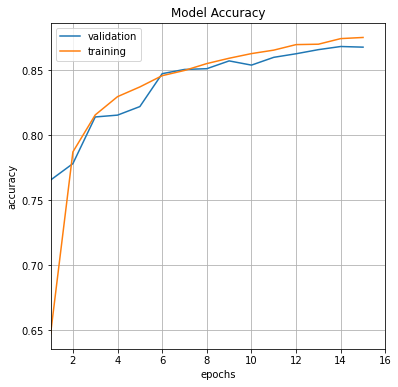

In [13]:
plot_accuracy_vs_epochs(basic_model_history)

In [14]:
y_pred = basic_model.predict(x_test).argmax(axis=1)
accuracy_score(y_test, y_pred)

0.8685

## observation. 
1. From above the training and validation accuracy is very good. 
2. Looks like test accuracy of the model also seems good.


# 2. Learning Rate scheduling (Step Decay)

In [15]:
# Manual setup for modifying leraning rates per epoch
# define step decay function
# Step decay helps to converge to minima faster as the learning is increased over the epcohs.
# often in DL, intial learning is important and later with larger steps the goal can be achieved faster. 

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.lrate = []
        
    def on_epoch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.lrate.append(step_decay(len(self.loss)))
        print('lrate:', step_decay(len(self.loss)))

def step_decay(epoch):
    initial_lrate = 0.005
    drop = 0.5 # new learning rate will be square root of the old leraning rate 
    drop_after_epochs = 2
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/drop_after_epochs))
    return lrate

In [16]:
step_scheduling_model = nn_model_fancy (
perceptrons_in_each_layer = 128,
hidden_activation = "relu",
initializer = tf.keras.initializers.RandomNormal(stddev=0.01),
dropout_rate = 0 ,
optimiser_type = tf.keras.optimizers.SGD(),
loss_fuction = "sparse_categorical_crossentropy",
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [17]:
batch_size = 128
epochs = 15

# learning schedule callback
lrate_step_decay = LearningRateScheduler(step_decay) 
loss_history_step_decay = LossHistory()
callbacks_list = [loss_history_step_decay, lrate_step_decay]

step_scheduling_model_history = step_scheduling_model.fit(X_train, y_train, 
                                                          batch_size=batch_size, 
                                                          epochs=epochs, 
                                                          validation_data=(X_val, y_val),
                                                          callbacks=callbacks_list)

Epoch 1/15
375/375 [==============================] - 2s 4ms/step - loss: 0.7246 - accuracy: 0.7359 - val_loss: 0.4946 - val_accuracy: 0.8240
lrate: 0.005
Epoch 2/15
375/375 [==============================] - 1s 3ms/step - loss: 0.4669 - accuracy: 0.8314 - val_loss: 0.4280 - val_accuracy: 0.8423
lrate: 0.0025
Epoch 3/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3876 - accuracy: 0.8613 - val_loss: 0.3814 - val_accuracy: 0.8604
lrate: 0.0025
Epoch 4/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3690 - accuracy: 0.8657 - val_loss: 0.3726 - val_accuracy: 0.8634
lrate: 0.00125
Epoch 5/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3445 - accuracy: 0.8753 - val_loss: 0.3612 - val_accuracy: 0.8659
lrate: 0.00125
Epoch 6/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3367 - accuracy: 0.8788 - val_loss: 0.3601 - val_accuracy: 0.8672
lrate: 0.000625
Epoch 7/15
375/375 [==============================] - 1s 3ms/

In [18]:
y_pred = step_scheduling_model.predict(x_test).argmax(axis=1)
accuracy_score(y_test, y_pred)

0.8777

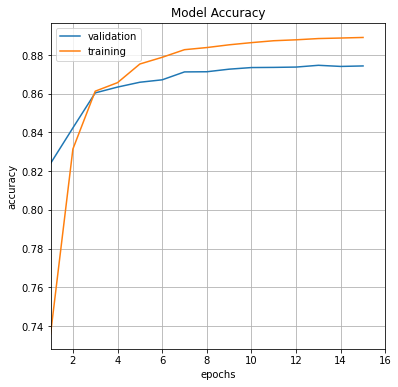

In [19]:
plot_accuracy_vs_epochs(step_scheduling_model_history)

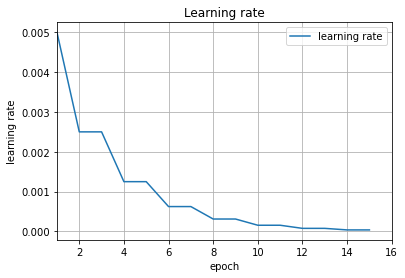

In [20]:
plot_learning_rate(loss_history_step_decay)

## observation.
1. Train and validation accuracy is increased from previous model.
2. The learning rate of model was not constant and accelerated as the epoch incresed.
3. time taken to build the model was faster from previous model. 

# 3. Adaptive Optimiser (Adam)

In [21]:
# earlier we have seen the model performance with SGD, in this case changing the optimised to adam.

adam_optimiser_model = nn_model_fancy (
perceptrons_in_each_layer = 128,
hidden_activation = "relu",
initializer = tf.keras.initializers.RandomNormal(stddev=0.01),
dropout_rate = 0 ,
optimiser_type = "adam",
loss_fuction = "sparse_categorical_crossentropy",
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [22]:
batch_size = 128
epochs = 15

adam_optimiser_model_history = adam_optimiser_model.fit(X_train, y_train, \
                                            batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/15
375/375 [==============================] - 2s 4ms/step - loss: 0.5464 - accuracy: 0.7990 - val_loss: 0.4279 - val_accuracy: 0.8439
Epoch 2/15
375/375 [==============================] - 1s 3ms/step - loss: 0.4130 - accuracy: 0.8518 - val_loss: 0.4210 - val_accuracy: 0.8485
Epoch 3/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3701 - accuracy: 0.8661 - val_loss: 0.3857 - val_accuracy: 0.8590
Epoch 4/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3531 - accuracy: 0.8720 - val_loss: 0.3834 - val_accuracy: 0.8596
Epoch 5/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3247 - accuracy: 0.8810 - val_loss: 0.3552 - val_accuracy: 0.8773
Epoch 6/15
375/375 [==============================] - 1s 3ms/step - loss: 0.3140 - accuracy: 0.8857 - val_loss: 0.3425 - val_accuracy: 0.8752
Epoch 7/15
375/375 [==============================] - 1s 3ms/step - loss: 0.2983 - accuracy: 0.8908 - val_loss: 0.3598 - val_accuracy: 0.8763
Epoch 

In [23]:
y_pred = adam_optimiser_model.predict(x_test).argmax(axis=1)
accuracy_score(y_test, y_pred)

0.8842

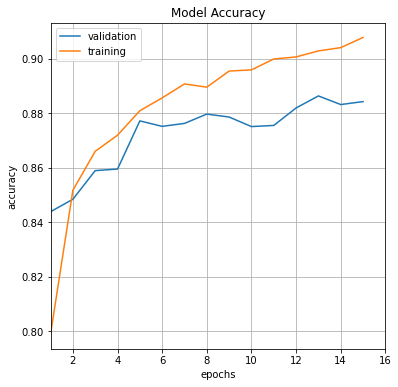

In [24]:
plot_accuracy_vs_epochs(adam_optimiser_model_history)

## observation.
1. Training accuracy with adam was lot better to compare to previous models.
2. Due to faster convergence model execution time was fast. 


# 4. Hyperparameter tuning the architecture with KerasTuner.

In [25]:
hp = kt.HyperParameters()

In [26]:
def build_model(hp):
    model = keras.Sequential()
    # input layer
    model.add(
        layers.Dense(input_shape=(784,),
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # hidden layer 1
    model.add(
        layers.Dense(
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Hidden layer 2
    model.add(
        layers.Dense(
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [27]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="Arch_tuning_dir",
    project_name="Fashion_MNIST",
)

In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [29]:
tuner.search(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

Trial 3 Complete [00h 00m 21s]
val_loss: 0.46390217542648315

Best val_loss So Far: 0.46390217542648315
Total elapsed time: 00h 01m 02s


In [30]:
tuner.results_summary()

Results summary
Results in Arch_tuning_dir/Fashion_MNIST
Showing 10 best trials
Trial summary
Hyperparameters:
units: 160
activation: relu
dropout: False
lr: 0.0011945519459253546
Score: 0.46390217542648315
Trial summary
Hyperparameters:
units: 288
activation: relu
dropout: True
lr: 0.004367902666291477
Score: 0.6000736951828003
Trial summary
Hyperparameters:
units: 96
activation: tanh
dropout: False
lr: 0.003962951078071285
Score: 1.41168874502182


## observation
1. We got model best parameters and need of drop layer etc
2. We haven't got the best optimised and initializer, in the next step using gridsearch cv that can be done.

# 5. Grid search CV for the rest of the parameters. 
### Use the optimised archtecture and tune other parameters

In [31]:
model = KerasClassifier(build_fn = nn_model_fancy)

In [32]:
params={'perceptrons_in_each_layer': [ 160],
        'hidden_activation': ["tanh" ],
        'initializer': [tf.keras.initializers.RandomNormal(mean=0., stddev=1.), tf.keras.initializers.Zeros(), \
                        tf.keras.initializers.Ones() ],
        'dropout_rate': [0.25],
        'optimiser_type': [tf.keras.optimizers.SGD(learning_rate=0.0004) , "adam", "adagrad"],
        'loss_fuction': ["sparse_categorical_crossentropy" ],
        'nb_epoch':[15]
        }

gs=GridSearchCV(estimator=model, param_grid=params, cv=2)

# now fit the dataset to the GridSearchCV object. 
gs = gs.fit(X_train, y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 160)               125600    
_________________________________________________________________
dense_5 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_6 (Dense)              (None, 160)               25760     
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1610      
Total params: 178,730
Trainable params: 178,730
Non-trainable params: 0
_________________________________________________________________
750/750 [==============================] - 2s 2ms/step - loss: 2.5771 - accuracy: 0.1649
Model: "sequential_2"
___

In [33]:
gs.best_params_

{'dropout_rate': 0.25,
 'hidden_activation': 'tanh',
 'initializer': <keras.initializers.initializers_v2.RandomNormal at 0x7f5c6820d950>,
 'loss_fuction': 'sparse_categorical_crossentropy',
 'nb_epoch': 15,
 'optimiser_type': 'adam',
 'perceptrons_in_each_layer': 160}

In [34]:
gs.best_score_

0.6662916839122772

## observation
1. In this step we are able to get the rest of the best hyperparemeters to build the model.
2. Early stopping in one method that helps in save time and compute, in the next step, we will build a model with best parameters and early stop.

# 6. Early Stopping 
### if with 5 epochs with no improvement after which training will be stopped. (helps is time and compute)

In [35]:
callback_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [36]:
Early_stopping_model = nn_model_fancy (
perceptrons_in_each_layer = 160,
hidden_activation = "tanh",
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
dropout_rate = 0.25 ,
optimiser_type = "adam",
loss_fuction = "sparse_categorical_crossentropy",
)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 160)               125600    
_________________________________________________________________
dense_81 (Dense)             (None, 160)               25760     
_________________________________________________________________
dense_82 (Dense)             (None, 160)               25760     
_________________________________________________________________
dropout_19 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 10)                1610      
Total params: 178,730
Trainable params: 178,730
Non-trainable params: 0
_________________________________________________________________


In [37]:
batch_size = 128
epochs = 100

Early_stopping_model_history_with_early_stopping = Early_stopping_model.fit(X_train, y_train, 
                                                        batch_size=batch_size, 
                                                        epochs=epochs, 
                                                        callbacks=[callback_early_stop],
                                                        validation_data=(X_val, y_val))

Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 1.4379 - accuracy: 0.5004 - val_loss: 0.9155 - val_accuracy: 0.6655
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9401 - accuracy: 0.6513 - val_loss: 0.8344 - val_accuracy: 0.6901
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8591 - accuracy: 0.6810 - val_loss: 0.7901 - val_accuracy: 0.7025
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8274 - accuracy: 0.6911 - val_loss: 0.7804 - val_accuracy: 0.7038
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8001 - accuracy: 0.6990 - val_loss: 0.7486 - val_accuracy: 0.7177
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.7771 - accuracy: 0.7062 - val_loss: 0.7266 - val_accuracy: 0.7324
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.7616 - accuracy: 0.7149 - val_loss: 0.7333 - val_accuracy: 0.7250

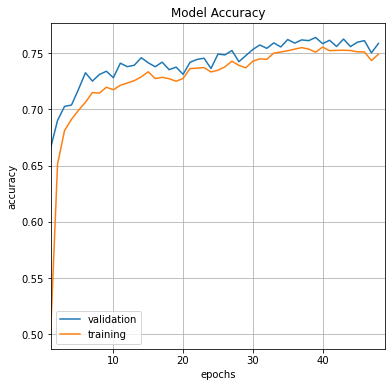

In [38]:
plot_accuracy_vs_epochs(Early_stopping_model_history_with_early_stopping)

## observation
1. With early stopping and correct parameters the model accuracy has come down. but, the model confidence in this will be high on unseen data as early stopping adressed the problem of model over fitting.
2. With this we will go ahead with this model for validation on unseen data

# 7. Manual Prediction check 

The predicted label is: 0
The actual label is:  0


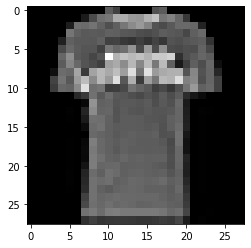

In [39]:
model_prediction(Early_stopping_model, 9)

**Label defination**

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

# 8. Overall Test Accuracy 

In [40]:
y_pred = Early_stopping_model.predict(x_test).argmax(axis=1)
accuracy_score(y_test, y_pred)

0.7614

## observation
1. The test accuracy of the model is 73%. The early stopping model train and validation accuracy is was almost 73%. This concludes that model is generic. This model output can be trusted with 73% confidence. 

******  END ***** 